In [1]:
# imports cell
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import warnings

# to create a tensor on the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

In [2]:
filename = "./dataset/icml_face_data.csv"

#emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [3]:
dataset_df = pd.read_csv(filename)
dataset_df

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


array([[<AxesSubplot:title={'center':'emotion'}>]], dtype=object)

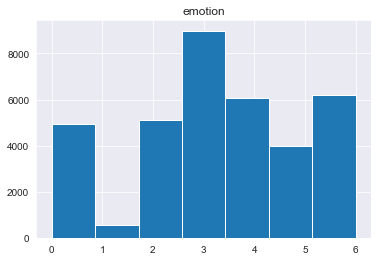

In [4]:
dataset_df.hist(column='emotion',bins=7)

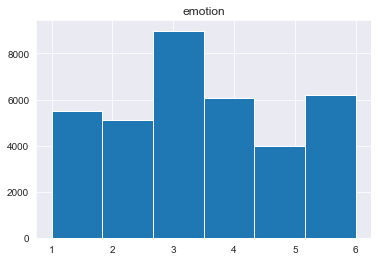

In [5]:
dataset_df['emotion'] = dataset_df['emotion'].replace(to_replace=0,value=1)
dataset_df.hist(column='emotion',bins=6)

emotions = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [6]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels and pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 1, 48, 48))
    image_label = np.array(list(map(int, data['emotion']))).reshape(len(data), 1)

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (1, 48, 48))
        image_array[i] = image

    return image_array, image_label

In [7]:
x_train, y_train = prepare_data(dataset_df[dataset_df[' Usage'] == 'Training'])
x_val, y_val = prepare_data(dataset_df[dataset_df[' Usage'] == 'PrivateTest'])
x_test, y_test = prepare_data(dataset_df[dataset_df[' Usage'] == 'PublicTest'])

In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((28709, 1, 48, 48),
 (28709, 1),
 (3589, 1, 48, 48),
 (3589, 1),
 (3589, 1, 48, 48),
 (3589, 1))

In [9]:
le = OneHotEncoder()
y_train = le.fit_transform(y_train).toarray()
y_val = le.fit_transform(y_val).toarray()
y_test = le.fit_transform(y_test).toarray()
y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [10]:
class MyDataset(Dataset):
    def __init__(self, array, labels):
        self.array = array
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.array[index], dtype=torch.float32, device=device), torch.tensor(self.labels[index],
                                                                                                 dtype=torch.float32,
                                                                                                 device=device)

    def __len__(self):
        return len(self.array)

In [11]:
trainDataset = MyDataset(x_train, y_train)

train_dataloader = DataLoader(trainDataset, batch_size=256, shuffle=True)

In [12]:
valDataset = MyDataset(x_val, y_val)

val_dataloader = DataLoader(valDataset, batch_size=256, shuffle=True)

In [13]:
testDataset = MyDataset(x_test, y_test)

test_dataloader = DataLoader(testDataset, batch_size=256, shuffle=True)

In [14]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # output size : (width - filter + 2*padding)/stride +1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('relu'))
        self.bn1 = nn.BatchNorm2d(num_features=8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('relu'))
        self.bn2 = nn.BatchNorm2d(num_features=16)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(35344, 1024)  # dim c * w * h
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

        self.fc2 = nn.Linear(1024, 512)  # dim c * w * h
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

        self.fc3 = nn.Linear(512, 256)  # dim c * w * h
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

        self.fc4 = nn.Linear(256, 6)
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, data):
        data = self.conv1(data)
        data = F.relu(data)
        data = self.bn1(data)
        data = F.max_pool2d(data, kernel_size=3, stride=1,padding=1)

        data = self.conv2(data)
        data = F.relu(data)
        data = self.bn2(data)
        data = F.max_pool2d(data, kernel_size=2, stride=1)

        data = torch.flatten(data, 1)

        data = self.fc1(data)
        data = F.relu(data)

        data = self.dropout(data)

        data = self.fc2(data)
        data = F.relu(data)

        data = self.dropout(data)

        data = self.fc3(data)
        data = F.relu(data)

        data = self.dropout(data)

        data = self.fc4(data)

        return data

In [15]:
def train_model(model, dataloader, optimizer):
    model.train()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    for (data, label) in dataloader:
        # reset gradients (it will accumulate gradients otherwise)
        optimizer.zero_grad()

        # forward pass
        output = model(data)

        # compute loss
        loss_ = loss(output, label)
        total_loss += loss_.item()

        # backward propagation dl/dw -> gradients
        loss_.backward()

        # update weights
        optimizer.step()

        ######################################

        _, predicted = torch.max(output.data, dim=1)
        _, true_label = torch.max(label, dim=1)
        pred += predicted.tolist()
        labels += true_label.tolist()

    return accuracy_score(labels, pred) * 100., total_loss / len(dataloader)

In [16]:
def test_model(model, dataloader):
    model.eval()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for (data, label) in dataloader:
            output = model(data)

            # compute loss
            loss_ = loss(output, label)
            total_loss += loss_.item()

            _, predicted = torch.max(output.data, dim=1)
            _, true_label = torch.max(label, dim=1)
            pred += predicted.tolist()
            labels += true_label.tolist()

    return labels, pred, accuracy_score(labels, pred) * 100., total_loss / len(dataloader)

In [17]:
model_path = "./cnn_model.pth"

model = CNN_Model().to(device)

#model.load_state_dict(torch.load(model_path))

print('Number of Parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of Parameters :  36852246


In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [19]:
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5, threshold=0.01)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer,step_size=6,gamma=0.1)

In [20]:
# chkpt = torch.load("./cnn_epoch10early_stop.pth")
# model.load_state_dict(chkpt['net_state'])
# optimizer.load_state_dict(chkpt['optimizer_state'])
# epoch_saved = chkpt['epoch'] + 1

In [21]:
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

In [22]:
epoch = 100
# Train and validate model

for e in range(epoch):
    train_accuracy, train_loss = train_model(model, train_dataloader, optimizer)

    val_labels, val_pred, val_accuracy, val_loss = test_model(model, val_dataloader)

    # Decay Learning Rate
    if e > 6:
        scheduler1.step(val_loss)
    else:
        scheduler2.step(e)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

    print('epoch: ', e + 1, 'Training loss: ', train_loss, 'Training Accuracy: ', train_accuracy, '%', '  Val loss: ',
          val_loss, 'Val Accuracy: ', val_accuracy, '%')
    print('learning rate :', optimizer.state_dict()['param_groups'][0]['lr'])

    # early stopping
    if train_accuracy - val_accuracy > 25:
        early_stop_path = "./cnn_epoch" + str(e) + "_early_stop.pth"
        info_dict = {
            'epoch': e,
            'net_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }
        torch.save(info_dict, early_stop_path)
        break

    # checkpoint
    if e % 5 == 0 and e > 0:
        early_stop_path = "./cnn_epoch" + str(e) + "_checkpoint.pth"
        info_dict = {
            'epoch': e,
            'net_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }
        torch.save(info_dict, early_stop_path)



epoch:  1 Training loss:  1.9618901615649198 Training Accuracy:  23.961127172663623 %   Val loss:  1.6262672583262126 Val Accuracy:  33.74198941209251 %
learning rate : 0.001
epoch:  2 Training loss:  1.6110087706979397 Training Accuracy:  33.435508028841134 %   Val loss:  1.4798836390177408 Val Accuracy:  42.3237670660351 %
learning rate : 0.001
epoch:  3 Training loss:  1.4916570608594777 Training Accuracy:  39.492841965934026 %   Val loss:  1.3755594730377196 Val Accuracy:  44.88715519643355 %
learning rate : 0.001
epoch:  4 Training loss:  1.4167342196523616 Training Accuracy:  42.878539830715106 %   Val loss:  1.3259769121805827 Val Accuracy:  47.17191418222346 %
learning rate : 0.001
epoch:  5 Training loss:  1.3502453439003599 Training Accuracy:  45.38298094674144 %   Val loss:  1.3282198349634806 Val Accuracy:  49.06659236556144 %
learning rate : 0.001
epoch:  6 Training loss:  1.2846668610530616 Training Accuracy:  49.02992093071859 %   Val loss:  1.2853029727935792 Val Accura

KeyboardInterrupt: 

Test loss:  1.4334321737289428 Test Accuracy:  53.246029534689335 %


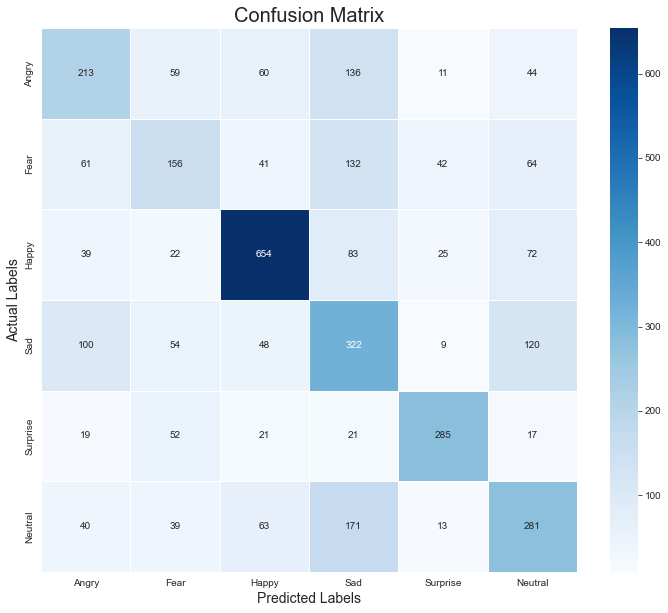

In [24]:
# test model

test_labels, test_pred, test_accuracy, test_loss = test_model(model, test_dataloader)
print('Test loss: ', test_loss, 'Test Accuracy: ', test_accuracy, '%')

cm = confusion_matrix(test_labels, test_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=emotions, columns=emotions)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
#torch.save(model.state_dict(), model_path)

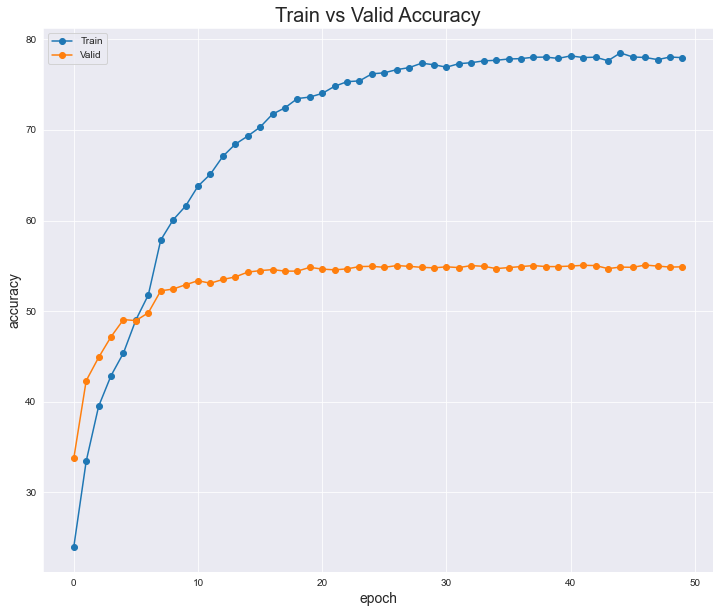

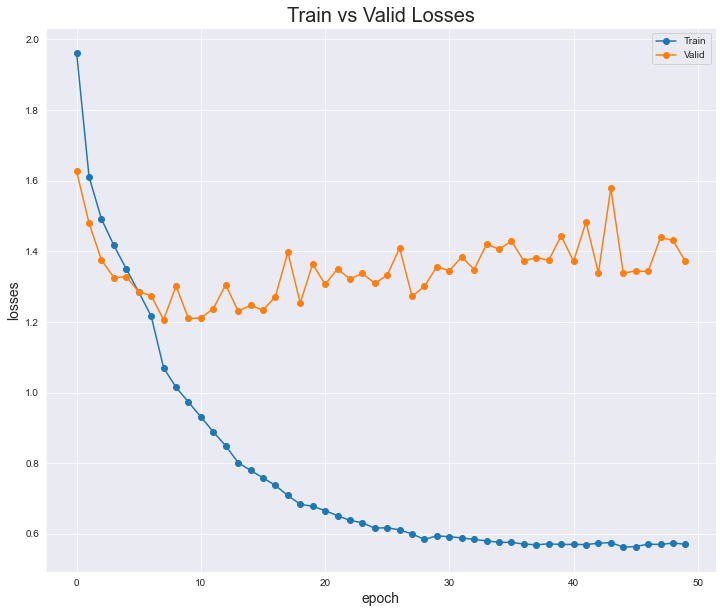

In [25]:
plt.figure(figsize=(12, 10))
plt.plot(train_acc_list, '-o')
plt.plot(val_acc_list, '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('accuracy', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy', size=20)

plt.show()

plt.figure(figsize=(12, 10))
plt.plot(train_loss_list, '-o')
plt.plot(val_loss_list, '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('losses', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses', size=20)

plt.show()